In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pandas as pd
from scipy.spatial import distance_matrix
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("../scripts")
from TrackReconstruction_functions import *

pd.options.mode.chained_assignment = None  # Disable the warning

pressure=5
# diffusion="0.0percent"
diffusion="nodiff"
# diffusion="0.05percent"
file_id = "1"
# diffusion = "next1t"

diff_name = f"_{diffusion}"
if diff_name == "_nodiff":
    diff_name=""

hits_true = pd.read_hdf(f"../data/ATPC_0nubb/ATPC_0nubb_{pressure}bar_EFilt_smear_{file_id}.h5", "MC/hits")
hits      = pd.read_hdf(f"../data/ATPC_0nubb/ATPC_0nubb_{pressure}bar_EFilt{diff_name}_smear_{file_id}.h5", "MC/hits")

# hits_true = pd.read_hdf(f"../data/ATPC_Bi/ATPC_Bi_ion_{pressure}bar_Efilt_smear_{file_id}_4.h5", "MC/hits")
# hits      = pd.read_hdf(f"../data/ATPC_Bi/ATPC_Bi_ion_{pressure}bar_Efilt_{diffusion}_smear_{file_id}_4.h5", "MC/hits")

# hits = pd.read_hdf(f"../data/Trackreco/ATPC_Tl_{pressure}bar_{diffusion}_filtered.h5", "MC/hits")
# hits_true = pd.read_hdf(f"../data/Trackreco/ATPC_Tl_{pressure}bar_nexus_filtered.h5", "MC/hits")
# hits_true["z"]= hits_true["z"]+3000

# hits_true = pd.read_hdf(f"../config/NextTonScale_Bi_ion.h5", "MC/hits")
# hits      = pd.read_hdf(f"../config/NextTonScale_Bi_ion_Efilt.h5", "MC/hits")
# hits_true["z"]= hits_true["z"]+1300

# hits_true = pd.read_hdf(f"../config/NextTon_0nubb.h5", "MC/hits")
# hits      = pd.read_hdf(f"../config/NextTon_0nubb_Efilt.h5", "MC/hits")
# hits_true["z"]= hits_true["z"]+1300


# hits = pd.read_hdf("../data/ATPC_0nubb/ATPC_0nubb_1bar_5.0percent_smear_3273_1.h5", "MC/hits")

display(hits)

event_list = hits.event_id.unique()

print(hits.event_id.unique())

,event_id,x,y,z,energy
0,176,-287.200531,1295.935547,1176.171753,0.034262
1,176,-300.616943,1298.171631,1178.407837,0.007994
2,176,-300.616943,1300.407715,1178.407837,0.008441
3,176,-296.144806,1298.171631,1178.407837,0.006852
4,176,-293.908752,1298.171631,1178.407837,0.006381
...,...,...,...,...,...
26251,244,-461.613831,-110.551163,1053.187988,0.000919
26252,244,-459.377777,-110.551163,1053.187988,0.006158
26253,244,-457.141693,-108.315094,1053.187988,0.003402
26254,244,-454.905640,-108.315094,1053.187988,0.015321


[176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 194
 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212
 213 214 215 216 218 219 220 221 222 223 224 225 226 227 229 230 231 232
 233 234 235 236 237 238 239 240 241 242 243 244]


In [2]:
# eid=9844
eid=event_list[7]

data = hits[hits.event_id ==eid]
data_true = hits_true[hits_true.event_id ==eid]
display(data_true)

print(data.energy.sum())
print(data_true.energy.sum())

,event_id,x,y,z,energy
2893,183,1123.758301,848.721985,2490.979736,0.000944
2894,183,1121.522339,844.249878,2493.215820,0.001018
2895,183,1121.522339,846.485901,2493.215820,0.012122
2896,183,1123.758301,846.485901,2493.215820,0.001938
2897,183,1123.758301,848.721985,2493.215820,0.003676
...,...,...,...,...,...
3291,183,1085.745239,859.902344,2631.852051,0.005813
3292,183,1087.981323,857.666260,2631.852051,0.006533
3293,183,1090.217285,855.430176,2631.852051,0.003329
3294,183,1090.217285,857.666260,2631.852051,0.002559


2.4526207
2.4526207


In [3]:
hits.describe()

,event_id,x,y,z,energy
count,26256.000000,26256.000000,26256.000000,26256.000000,26256.000000
mean,209.705058,57.724880,-22.403870,1810.199097,0.006178
std,20.169533,768.008118,967.792542,913.780090,0.009806
min,176.000000,-1523.746094,-1742.880737,15.652476,0.000323
25%,192.000000,-483.974518,-819.384705,1021.883057,0.001930
50%,209.000000,-3.219900,-92.662621,1912.956177,0.003899
75%,227.000000,618.406982,826.361328,2522.284668,0.006559
max,244.000000,1682.775391,1781.162354,3528.515381,0.129805


In [ ]:

Diff_smear, energy_threshold, diff_scale_factor, radius_sf, group_sf, Tortuosity_dist, voxel_size, det_size  = InitializeParams(pressure, diffusion)
# voxel_sf=1.1
# energy_threshold=0
print("Diffussion smear is: ",        Diff_smear,            "mm/sqrt(cm)")
print("Energy threshold is: ",        1000*energy_threshold, "keV")
print("diffision scale factor is: ",  diff_scale_factor)
print("Radius scale factor is: ",     radius_sf)
print("Hit grouping factor is: ",     group_sf)
print("Tortuosity distance scale is:", Tortuosity_dist)
print("The voxel size is:",           voxel_size)
print("The det_size is", det_size)

# energy_threshold = 0.0004

mean_sigma = diff_scale_factor*Diff_smear*np.sqrt(0.1*data.z.mean())

# The expected diffusion is less than vox size so replace
if (mean_sigma < 1.5*voxel_size):
    mean_sigma = 1.5*voxel_size


if (diffusion == "next1t"):
    mean_sigma=6
elif (diffusion == "nodiff"):
    mean_sigma=10/np.sqrt(pressure)

print("Mean sigma", mean_sigma)

# Create the bins ---- 
xbw  = mean_sigma
xmin = -det_size - mean_sigma/2 
xmax = det_size  + mean_sigma/2

ybw  = mean_sigma
ymin = -det_size - mean_sigma/2 
ymax = det_size  + mean_sigma/2

# This shifts the z pos of the events so 0 is at anode
# can set this to zero
z_shift = det_size
# z_shift = 0

zbw=mean_sigma
zmin=-det_size + z_shift - mean_sigma/2 
zmax=det_size + z_shift + mean_sigma/2

# bins for x, y, z
xbins = np.arange(xmin, xmax+xbw, xbw)
ybins = np.arange(ymin, ymax+ybw, ybw)
zbins = np.arange(zmin, zmax+zbw, zbw)

# center bins for x, y, z
xbin_c = xbins[:-1] + xbw / 2
ybin_c = ybins[:-1] + ybw / 2
zbin_c = zbins[:-1] + zbw / 2


Diffussion smear is:  0.1 mm/sqrt(cm)
Energy threshold is:  0.3 keV
diffision scale factor is:  7
Radius scale factor is:  5
Hit grouping factor is:  10
Tortuosity distance scale is: 14.0
The voxel size is: 2.23606797749979
The det_size is 1807.7267582900142
Mean sigma 4.47213595499958


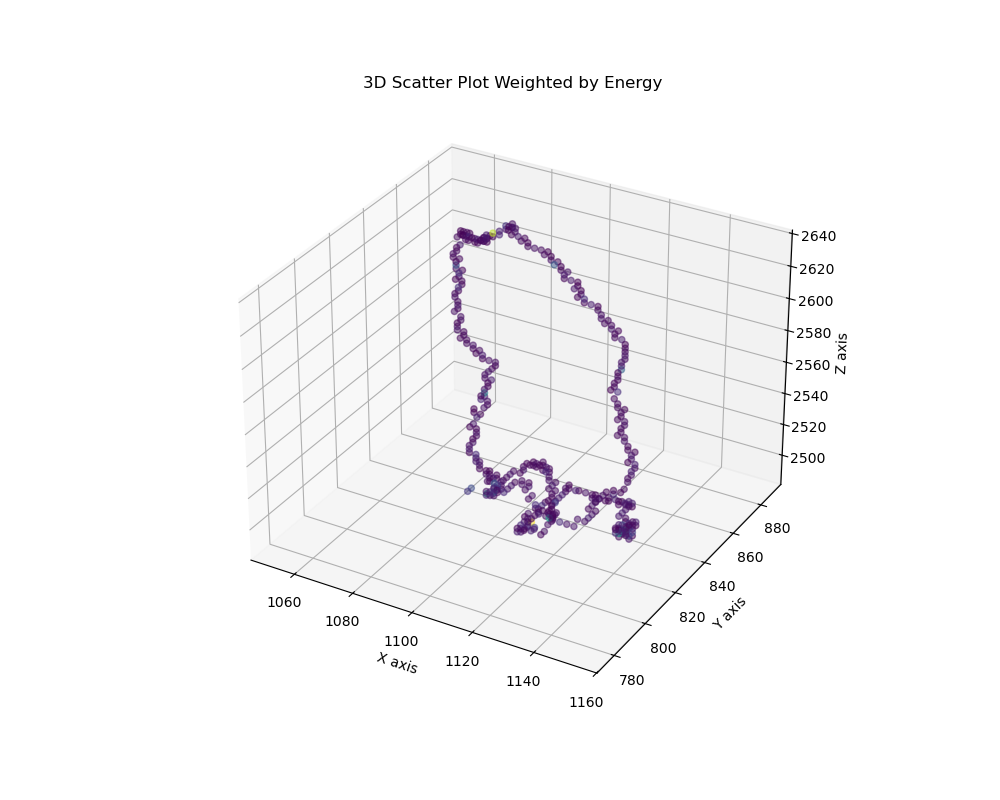

In [5]:
%matplotlib widget 

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Normalize the energy values for the colors
cmap = plt.get_cmap('viridis')
norm = plt.Normalize(data.energy.min(), data.energy.max())
colors = cmap(norm(data.energy))


# Plot the scatter plot
scatter = ax.scatter(data.x, data.y, data.z, c=colors, marker='o', alpha=0.5)
# ax.scatter(data_true['x'], data_true['y'], data_true['z'], marker='o', c="DarkOrange")

# ax.scatter(data_true['x'], data_true['y'], data_true['z']+3000, marker='o', c="DarkRed")

# Add color bar to indicate energy values
mappable = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
mappable.set_array(data.energy)
# cbar = plt.colorbar(mappable)
# cbar.set_label('Energy')

# Set labels and title
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.set_title('3D Scatter Plot Weighted by Energy')

plt.show()

In [6]:
print(data.energy.sum())

# If there are overlapping voxels, merge them. Otherwise the energy gets messed up
data = (data.groupby(["event_id", "x", "y", "z"], as_index=False)["energy"].sum())

# display(data)
data = data[['event_id','x', 'y', 'z',"energy"]]

# then sort it based on the x,y,z
data = data.sort_values(by=['x', "y", "z"]).reset_index(drop=True)

print(data.energy.sum())
display(data)

2.4526207
2.4526207


,event_id,x,y,z,energy
0,183,1052.204224,884.499084,2593.838867,0.003726
1,183,1052.204224,886.735168,2593.838867,0.000397
2,183,1052.204224,886.735168,2596.074951,0.001093
3,183,1054.440308,877.790894,2587.130615,0.001838
4,183,1054.440308,877.790894,2589.366699,0.004074
...,...,...,...,...,...
398,183,1152.827271,801.764587,2564.770020,0.002658
399,183,1152.827271,804.000610,2564.770020,0.004521
400,183,1152.827271,804.000610,2567.006104,0.008098
401,183,1152.827271,806.236694,2567.006104,0.002658


Mean z: 2551.6033  diffusion =  4.47213595499958
Mean Sigma:  4.47213595499958
Mean sigma group 15.973739


,x,y,z,energy,group_id
0,1053.806763,884.339172,2593.763428,0.018407,0
1,1056.139648,876.451782,2586.104736,0.040068,0
2,1054.440308,880.026978,2591.602783,0.002211,0
3,1056.423340,882.673157,2598.311035,0.009887,0
4,1058.544678,873.790222,2582.150146,0.022506,0
...,...,...,...,...,...
103,1144.628296,777.167847,2555.825684,0.017811,0
104,1143.882812,814.445068,2576.614502,0.007775,0
105,1143.422852,817.417053,2579.507080,0.011228,0
106,1148.355103,789.337830,2558.061768,0.010607,0


108 2.4526207731105387


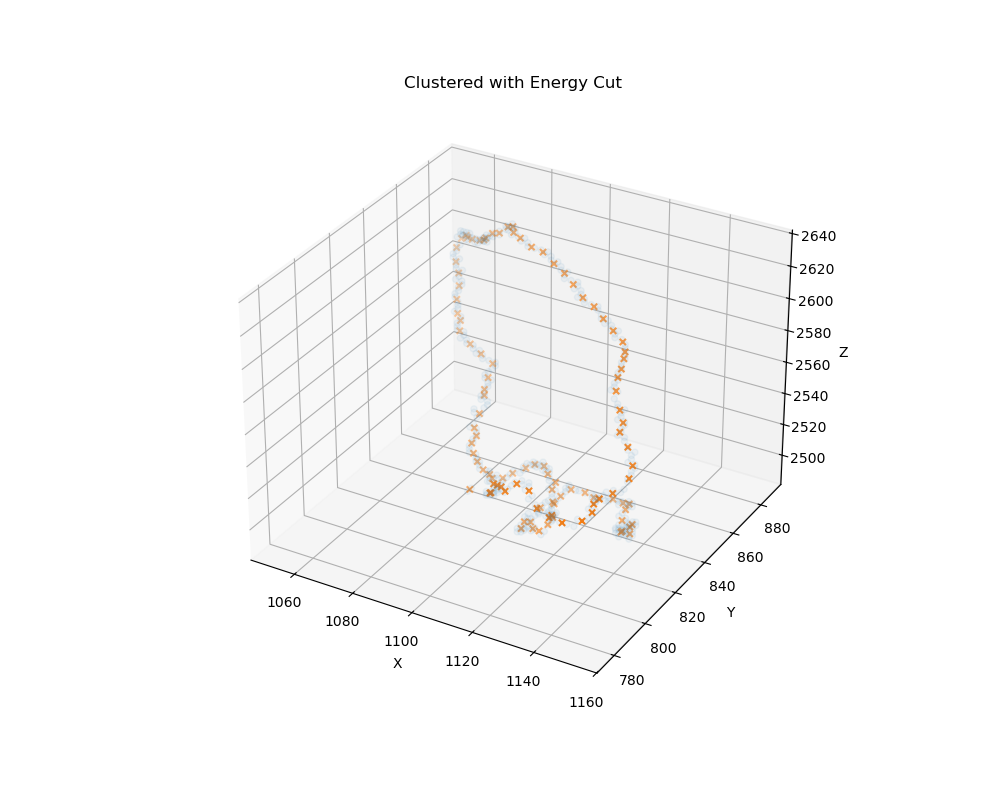

In [7]:

# display(data)

print("Mean z:", data.z.mean(), " diffusion = ", mean_sigma)
print("Mean Sigma: ", mean_sigma)

# Apply grouping
data_copy = data.copy()

df_merged = CutandRedistibuteEnergy(data_copy, energy_threshold)

mean_sigma_group = group_sf*Diff_smear*np.sqrt(0.1*data.z.mean())

if (mean_sigma_group < voxel_size/2.0):
    mean_sigma_group = voxel_size/2.0

if diffusion == "next1t":
    mean_sigma_group = 10
# elif (diffusion == "nodiff"):
#     mean_sigma_group=15
print("Mean sigma group", mean_sigma_group)

df_merged = GroupHits(df_merged, mean_sigma_group)

# Apply clustering
node_centers_df = []

for gid in sorted(df_merged.group_id.unique()):
    temp_df = df_merged[df_merged.group_id == gid]
    temp_df.reset_index(drop=True, inplace=True)
    node_centers_df.append(Cluster(temp_df, mean_sigma))

node_centers_df = pd.concat(node_centers_df, ignore_index=True)

display(node_centers_df)
print(len(node_centers_df), node_centers_df.energy.sum())

# -------

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Unclustered
# for gid in sorted(df_merged.group_id.unique()):
#     # ax.scatter(data['x'], data['y'], data['z'], marker='o',alpha=0.01)
#     # ax.scatter(data_true['x'], data_true['y'], data_true['z'], marker='o')
#     temp_df = df_merged[df_merged.group_id == gid]
#     ax.scatter(temp_df['x'], temp_df['y'], temp_df['z'], marker='x')

# Clustered
for gid in sorted(node_centers_df.group_id.unique()):
    ax.scatter(df_merged['x'], df_merged['y'], df_merged['z'], marker='o',alpha=0.05)
    # ax.scatter(data_true['x'], data_true['y'], data_true['z'], marker='o')
    temp_df = node_centers_df[node_centers_df.group_id == gid]
    ax.scatter(temp_df['x'], temp_df['y'], temp_df['z'], marker='x')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Clustered with Energy Cut')
plt.show()



In [8]:


databin = node_centers_df.copy()
databin["event_id"] = eid


# Now lets bin the data
databin['x_smear'] = pd.cut(x=databin['x'], bins=xbins,labels=xbin_c, include_lowest=True)
databin['y_smear'] = pd.cut(x=databin['y'], bins=ybins,labels=ybin_c, include_lowest=True)
databin['z_smear'] = pd.cut(x=databin['z'], bins=zbins,labels=zbin_c, include_lowest=True)

# Drop rows with any NaN values
databin = databin.dropna()

# Dictionary to store results
aggregated_data = {}

# Iterate through the DataFrame row by row
for _, row in databin.iterrows():
    key = (row['event_id'], row['x_smear'], row['y_smear'], row['z_smear'], row['group_id'])
    
    if key not in aggregated_data:
        # Initialize the aggregation for a new group
        aggregated_data[key] = {
            'x_sum': row['x'],
            'y_sum': row['y'],
            'z_sum': row['z'],
            'energy_sum': row['energy'],
            'group_id' : row['group_id'],
            'count': 1
        }
    else:
        # Update existing group values
        aggregated_data[key]['x_sum'] += row['x']
        aggregated_data[key]['y_sum'] += row['y']
        aggregated_data[key]['z_sum'] += row['z']
        aggregated_data[key]['energy_sum'] += row['energy']
        aggregated_data[key]['group_id'] = row['group_id']
        aggregated_data[key]['count'] += 1

# Convert aggregated data into a DataFrame
result = []
for key, values in aggregated_data.items():
    event_id, x_smear, y_smear, z_smear, group_id = key
    result.append({
        'event_id': event_id,
        'x_smear': x_smear,
        'y_smear': y_smear,
        'z_smear': z_smear,
        'x': values['x_sum'] / values['count'],   # Mean x
        'y': values['y_sum'] / values['count'],   # Mean y
        'z': values['z_sum'] / values['count'],   # Mean z
        'energy': values['energy_sum'],           # Sum energy
        'group_id' : int(group_id)
    })

# Create final DataFrame
databin = pd.DataFrame(result)

# then sort it based on the x,y,z
# databin = databin.sort_values(by=['x', "y", "z"]).reset_index(drop=True)


display(databin)


,event_id,x_smear,y_smear,z_smear,x,y,z,energy,group_id
0,183.0,1054.440253,884.499087,2593.838854,1053.806763,884.339172,2593.763428,0.018407,0
1,183.0,1054.440253,875.554815,2584.894582,1056.139648,876.451782,2586.104736,0.040068,0
2,183.0,1054.440253,880.026951,2589.366718,1054.440308,880.026978,2591.602783,0.002211,0
3,183.0,1054.440253,884.499087,2598.310990,1056.423340,882.673157,2598.311035,0.009887,0
4,183.0,1058.912389,875.554815,2580.422446,1058.544678,873.790222,2582.150146,0.022506,0
...,...,...,...,...,...,...,...,...,...
96,183.0,1139.410836,826.361319,2504.396135,1141.646851,826.780762,2505.054199,0.021189,0
97,183.0,1143.882972,777.167824,2553.589630,1144.628296,777.167847,2555.825684,0.017811,0
98,183.0,1143.882972,812.944911,2575.950310,1143.882812,814.445068,2576.614502,0.007775,0
99,183.0,1143.882972,817.417047,2580.422446,1143.422852,817.417053,2579.507080,0.011228,0


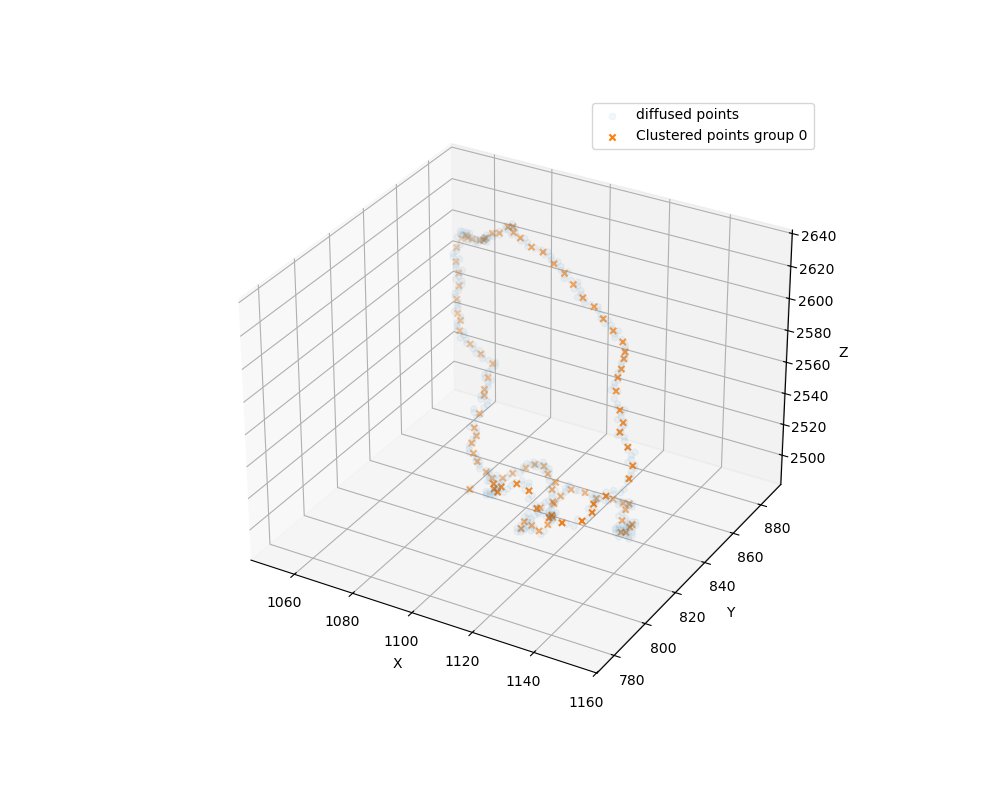

In [9]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')


ax.scatter(data['x'], data['y'], data['z'], marker='o',alpha=0.05, label = "diffused points")
# ax.scatter(data_true['x'], data_true['y'], data_true['z'], marker='o',color="Teal")


for gid in sorted(databin.group_id.unique()):

    temp_df = databin[databin.group_id == gid]
    ax.scatter(temp_df['x'], temp_df['y'], temp_df['z'], marker='x', label = f"Clustered points group {gid}")

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.legend()
plt.show()
plt.savefig("plots/clustering/clustered_hits1.pdf")

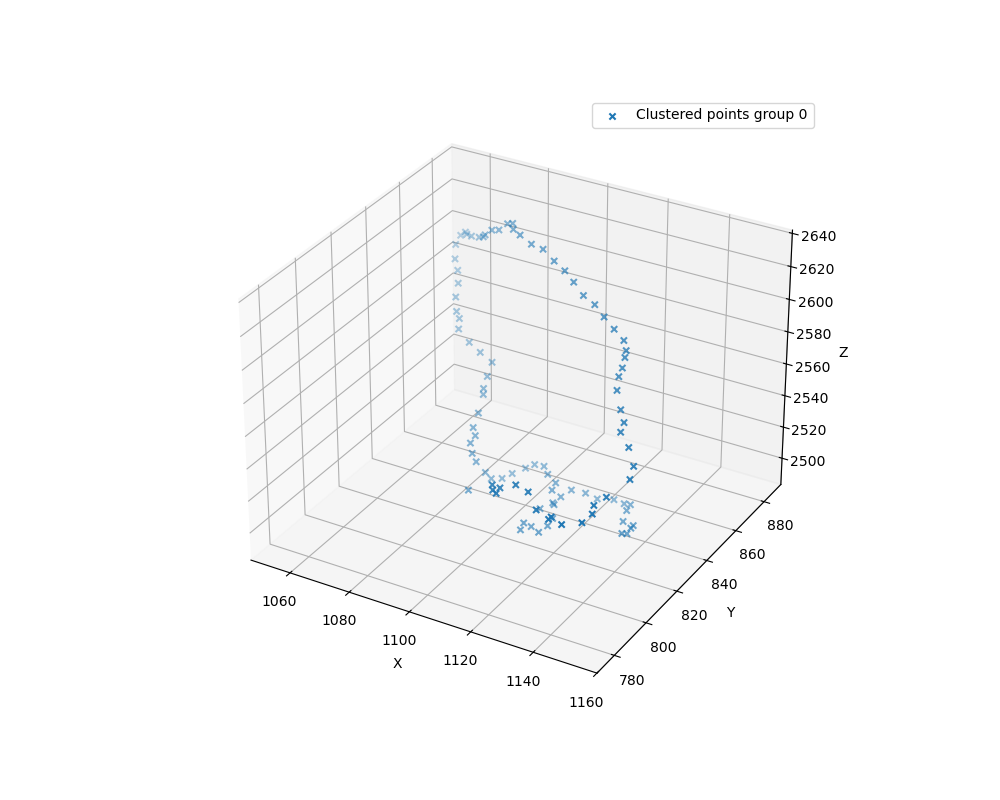

In [10]:

# Plot the original points and the polynomial fit
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for gid in sorted(databin.group_id.unique()):

    temp_df = databin[databin.group_id == gid]
    ax.scatter(temp_df['x'], temp_df['y'], temp_df['z'], marker='x', label = f"Clustered points group {gid}")

# ax.scatter(databin.x, databin.y,databin.z, color='blue', label='Clustered Points', alpha=0.5)
# ax.scatter(data_true['x'], data_true['y'], data_true['z'],s=0.1 ,marker='o',color="Teal")

# Labels and legend
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.show()
plt.savefig("plots/clustering/clustered_hits2.pdf")

In [11]:
display(databin)

# databin.to_hdf("../data/test/test.h5", "MC/hits")

print(databin.energy.sum())

databin["group_id"]=0

,event_id,x_smear,y_smear,z_smear,x,y,z,energy,group_id
0,183.0,1054.440253,884.499087,2593.838854,1053.806763,884.339172,2593.763428,0.018407,0
1,183.0,1054.440253,875.554815,2584.894582,1056.139648,876.451782,2586.104736,0.040068,0
2,183.0,1054.440253,880.026951,2589.366718,1054.440308,880.026978,2591.602783,0.002211,0
3,183.0,1054.440253,884.499087,2598.310990,1056.423340,882.673157,2598.311035,0.009887,0
4,183.0,1058.912389,875.554815,2580.422446,1058.544678,873.790222,2582.150146,0.022506,0
...,...,...,...,...,...,...,...,...,...
96,183.0,1139.410836,826.361319,2504.396135,1141.646851,826.780762,2505.054199,0.021189,0
97,183.0,1143.882972,777.167824,2553.589630,1144.628296,777.167847,2555.825684,0.017811,0
98,183.0,1143.882972,812.944911,2575.950310,1143.882812,814.445068,2576.614502,0.007775,0
99,183.0,1143.882972,817.417047,2580.422446,1143.422852,817.417053,2579.507080,0.011228,0


2.4526207731105387


Diffussion smear is:  0.1 mm/sqrt(cm)
Energy threshold is:  0.3 keV
diffision scale factor is:  7
Radius scale factor is:  5
Hit grouping factor is:  10
Tortuosity distance scale is: 14.0
The voxel size is: 2.23606797749979
The det half_length is:  1807.7267582900142
Median distance to the closest row: 4.864646766258893
Distances to iterate over [ 1  2  4  5  7  9 10 12 14 15 17 19 20 22 24]
Dist Thresh 21.996
Pass Flag: True
The primary track is:  0
     event_id            x           y            z  group_id    energy  id  \
0       183.0  1116.824829  788.348206  2553.179932         0  0.039174  57   
1       183.0  1119.286255  788.348145  2552.726074         0  0.008620  63   
2       183.0  1118.764709  785.054871  2554.128662         0  0.156621  60   
3       183.0  1121.923584  781.250702  2557.492798         0  0.052936  67   
4       183.0  1124.832886  787.413391  2558.586670         0  0.017885  69   
..        ...          ...         ...          ...       ...       ...

,event_id,x,y,z,group_id,energy,id,primary,trkID,cumulative_distance,angle,Tortuosity,Squiglicity
id,,,,,,,,,,,,,
57,183.0,1116.824829,788.348206,2553.179932,0,0.039174,57,1,0,0.000000,0.000000,1.241697,0.357356
63,183.0,1119.286255,788.348145,2552.726074,0,0.008620,63,1,0,2.502919,120.380302,1.241697,0.357356
60,183.0,1118.764709,785.054871,2554.128662,0,0.156621,60,1,0,6.120227,102.244166,1.957553,1.137658
67,183.0,1121.923584,781.250702,2557.492798,0,0.052936,67,1,0,12.100828,43.857973,1.794599,1.120088
69,183.0,1124.832886,787.413391,2558.586670,0,0.017885,69,1,0,19.002954,104.842135,1.659506,1.043878
...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,183.0,1140.769897,830.146912,2502.997559,0,0.032367,89,1,0,537.930942,58.949740,1.487545,0.691646
85,183.0,1140.205078,827.244904,2500.258789,0,0.227317,85,1,0,541.961020,94.698208,1.633622,0.802921
90,183.0,1141.646851,826.780762,2505.054199,0,0.021189,90,1,0,546.989946,128.443811,1.716155,0.791713


101 101


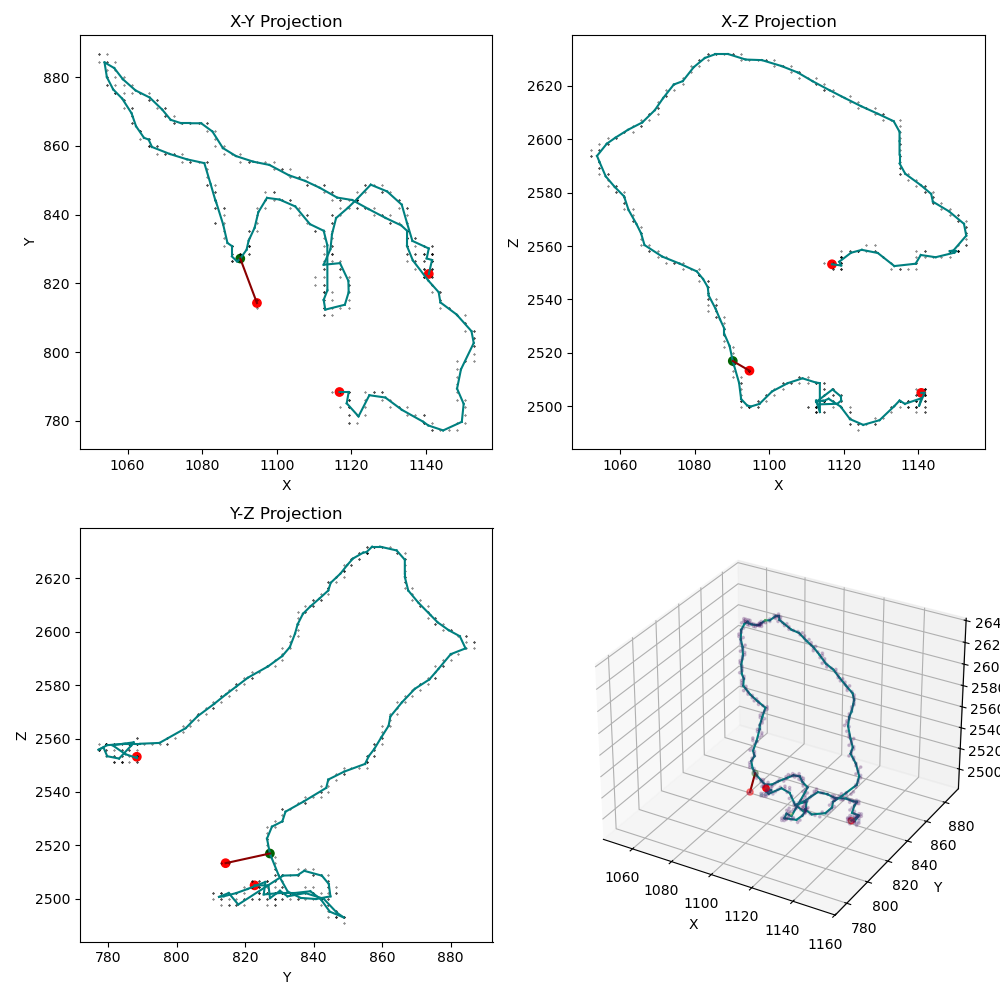

In [12]:
# Apply the tracking reconstruction

# df, Tracks, connected_nodes, connection_count, pass_flag = RunTracking(databin[["event_id", "x", "y", "z", "energy"]], 0, 1, "5percent", 0)
df, Tracks, connected_nodes, connection_count, pass_flag, contained = RunTracking(databin[["event_id", "x", "y", "z", "energy", "group_id"]], 0, pressure, diffusion, 0)

df.index = df.id

display(df)
print(len(df.x), len(df.z))

# Create subplots
fig = plt.figure(figsize=(10, 10))

axs = [fig.add_subplot(2, 2, i + 1) for i in range(3)]

# Plot xy projection
plot_tracks(axs[0], df['x'], df['y'], connection_count, 'X', 'Y', Tracks)
# axs[0].scatter(data.x, data.y, c=colors, marker='o', alpha=0.5,s=3)
axs[0].scatter(data_true['x'], data_true['y'], marker='o',c="k", s=0.1)

# Plot xz projection
plot_tracks(axs[1], df['x'], df['z'], connection_count, 'X', 'Z', Tracks)
# axs[1].scatter(data.x, data.z, c=colors, marker='o', alpha=0.5,s=3)
axs[1].scatter(data_true['x'], data_true['z'], marker='o',c="k", s=0.1)

# Plot yz projection
plot_tracks(axs[2], df['y'], df['z'], connection_count, 'Y', 'Z', Tracks)
# axs[2].scatter(data.y, data.z, c=colors, marker='o', alpha=0.5,s=3)
axs[2].scatter(data_true['y'], data_true['z'], marker='o',c="k", s=0.1)


# 3D Projection
ax_3D = fig.add_subplot(2, 2, 4, projection='3d')
plot_tracks_3D(ax_3D, df['x'], df['y'], df['z'], connection_count, Tracks)
# ax_3D.scatter(data_true['x'], data_true['y'], data_true['z'], marker='o',c="k", s=0.1)
# ax_3D.scatter(data.x, data.y, data.z, c=colors, marker='o', alpha=0.5,s=3)
ax_3D.scatter(df_merged.x, df_merged.y, df_merged.z, c=df_merged.energy, marker='o', alpha=0.2,s=3)
ax_3D.set_title("")


plt.tight_layout()
plt.show()

In [13]:
if (diffusion == "next1t"):
    temp_meta = GetTrackdf(df, Tracks, 30, 15, 15, pressure)
else:
    temp_meta = GetTrackdf(df, Tracks, 500/pressure, 180/pressure, 200/pressure, pressure) # scale these params inversely with the pressure

display(temp_meta)
# temp_meta = UpdateTrackMeta(temp_meta, df, 100/pressure) # Merge deltas and brems that are near the blobs in the metadata
temp_meta = UpdateTrackMeta2(temp_meta)
temp_meta["contained"] = contained
display(temp_meta)

,event_id,trkID,primary,start,end,length,energy,blob1,blob2,blob1R,blob2R,Tortuosity1,Tortuosity2,Squiglicity1,Squiglicity2,label
0,183.0,0,1,57,88,551.139,2.413497,0.560555,0.633363,0.496466,0.849999,1.475437,1.438378,0.730827,0.63298,Primary
0,183.0,1,0,32,37,14.162,0.039124,0.039124,0.039124,0.000000,0.039124,0.000000,0.000000,0.000000,0.00000,Delta0


,event_id,trkID,primary,start,end,length,energy,blob1,blob2,blob1R,blob2R,Tortuosity1,Tortuosity2,Squiglicity1,Squiglicity2,label,contained
0,183.0,0,1,57,88,551.139,2.413497,0.633363,0.560555,0.849999,0.496466,1.475437,1.438378,0.730827,0.63298,Primary,True
0,183.0,1,0,32,37,14.162,0.039124,0.039124,0.039124,0.039124,0.000000,0.000000,0.000000,0.000000,0.00000,Delta0,True


Text(0, 0.5, 'Angle')

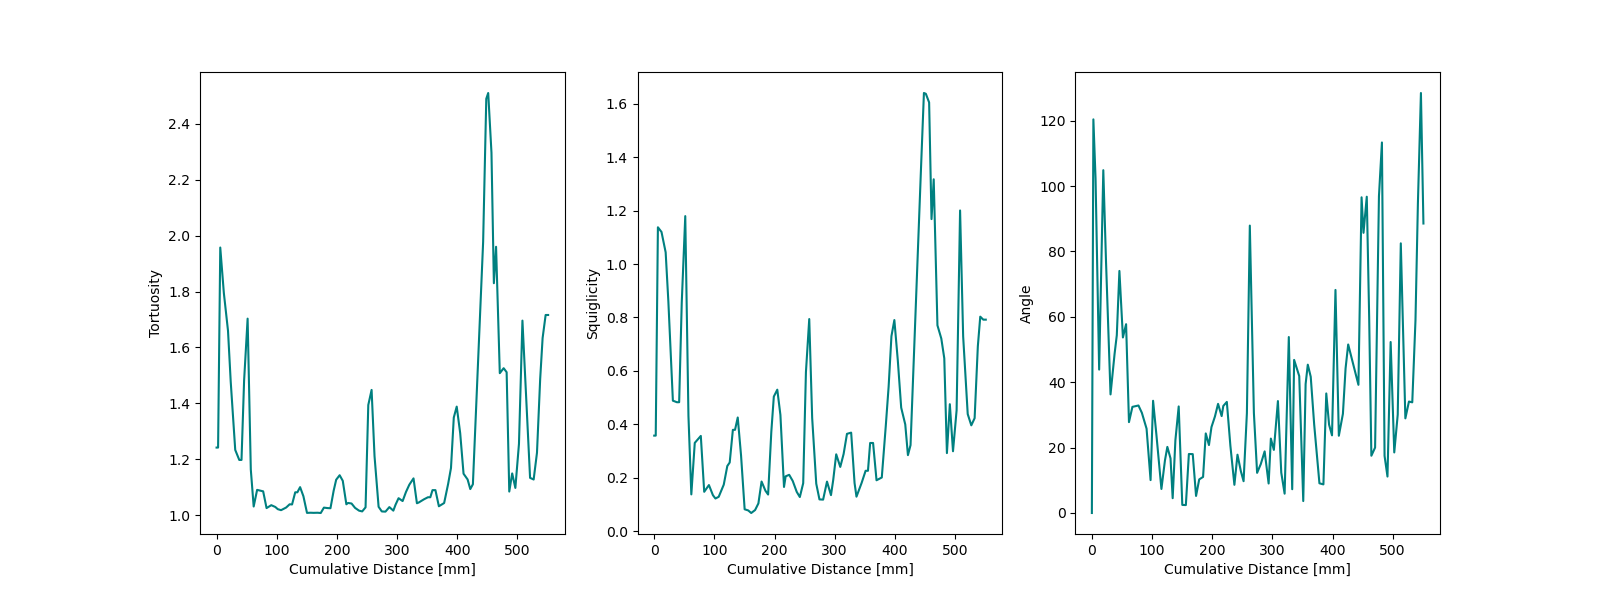

In [14]:

fig, axs = plt.subplots(1, 3, figsize=(16, 6))

axs[0].plot(df[df.primary == 1].cumulative_distance, df[df.primary == 1]["Tortuosity"], c="Teal")
axs[0].set_xlabel("Cumulative Distance [mm]")
axs[0].set_ylabel("Tortuosity")

axs[1].plot(df[df.primary == 1].cumulative_distance, df[df.primary == 1]["Squiglicity"], c="Teal")
axs[1].set_xlabel("Cumulative Distance [mm]")
axs[1].set_ylabel("Squiglicity")


axs[2].plot(df[df.primary == 1].cumulative_distance, df[df.primary == 1]["angle"], c="Teal")
axs[2].set_xlabel("Cumulative Distance [mm]")
axs[2].set_ylabel("Angle")